# A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network

Yomna Hesham Amin Fekry  *(G19093453)*

Ahmed Mohamed Farouk  *(2000630)*

This is an implementation to the paper **"A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network"**.

The author of the paper said that the proposed algorithm is implemented in Matlab, but we cannot find this implementation, so we implemented it in Python


# Imports


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt

from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam
#from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
from keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

# matplotlib Settings

In [4]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

# Methods Definitions

In [5]:
def denoise(data):
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

    datarec = pywt.waverec(coeffs, 'sym4')

    return datarec


# Variables Definitions

In [6]:
path = '/content/drive/MyDrive/Colab Notebooks/PPTK/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Prepere Input Files

In [7]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt
records = list()
annotations = list()
filenames.sort()

In [8]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)

    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

# Data Extraction and Preprocessing

<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-9-6f8c69895a3a>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
<ipython-input-9-6f8c69895a3a>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
<ipython-input-9-6f8c69895a3a>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
<ipython-input-9-6f8c69895a3a>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1 and not example_beat_printed:


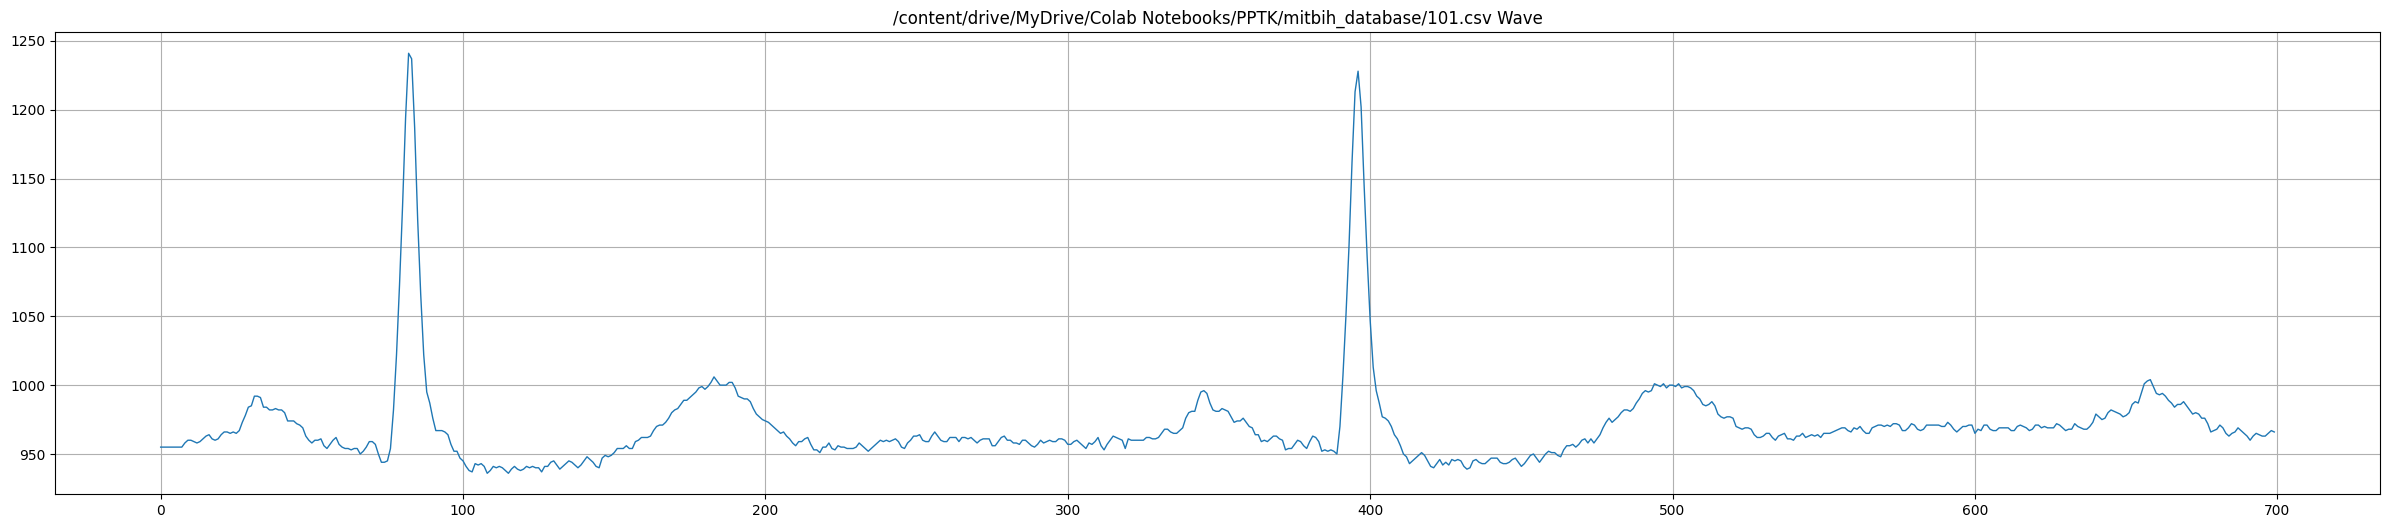

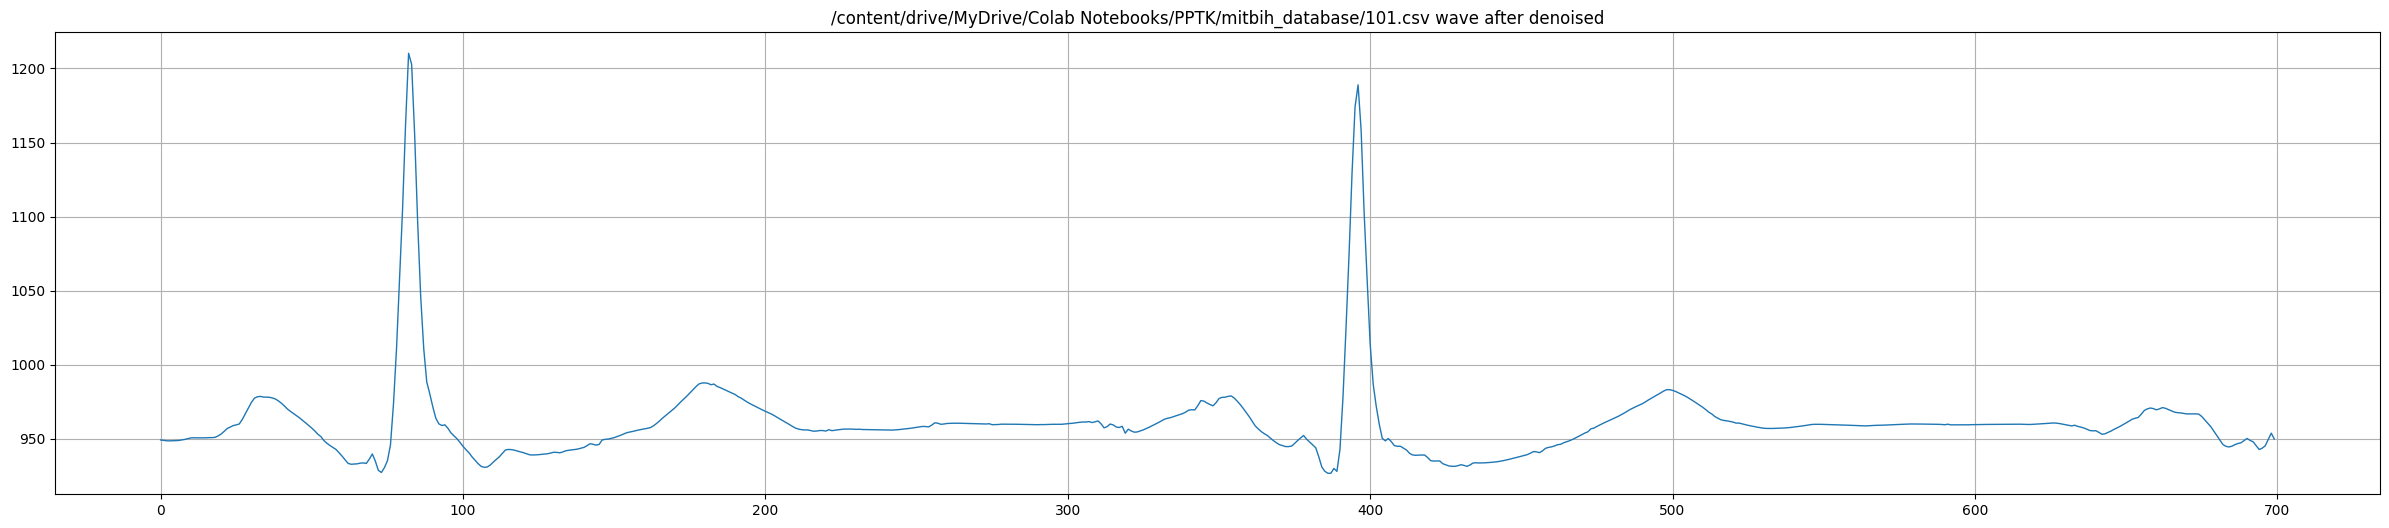

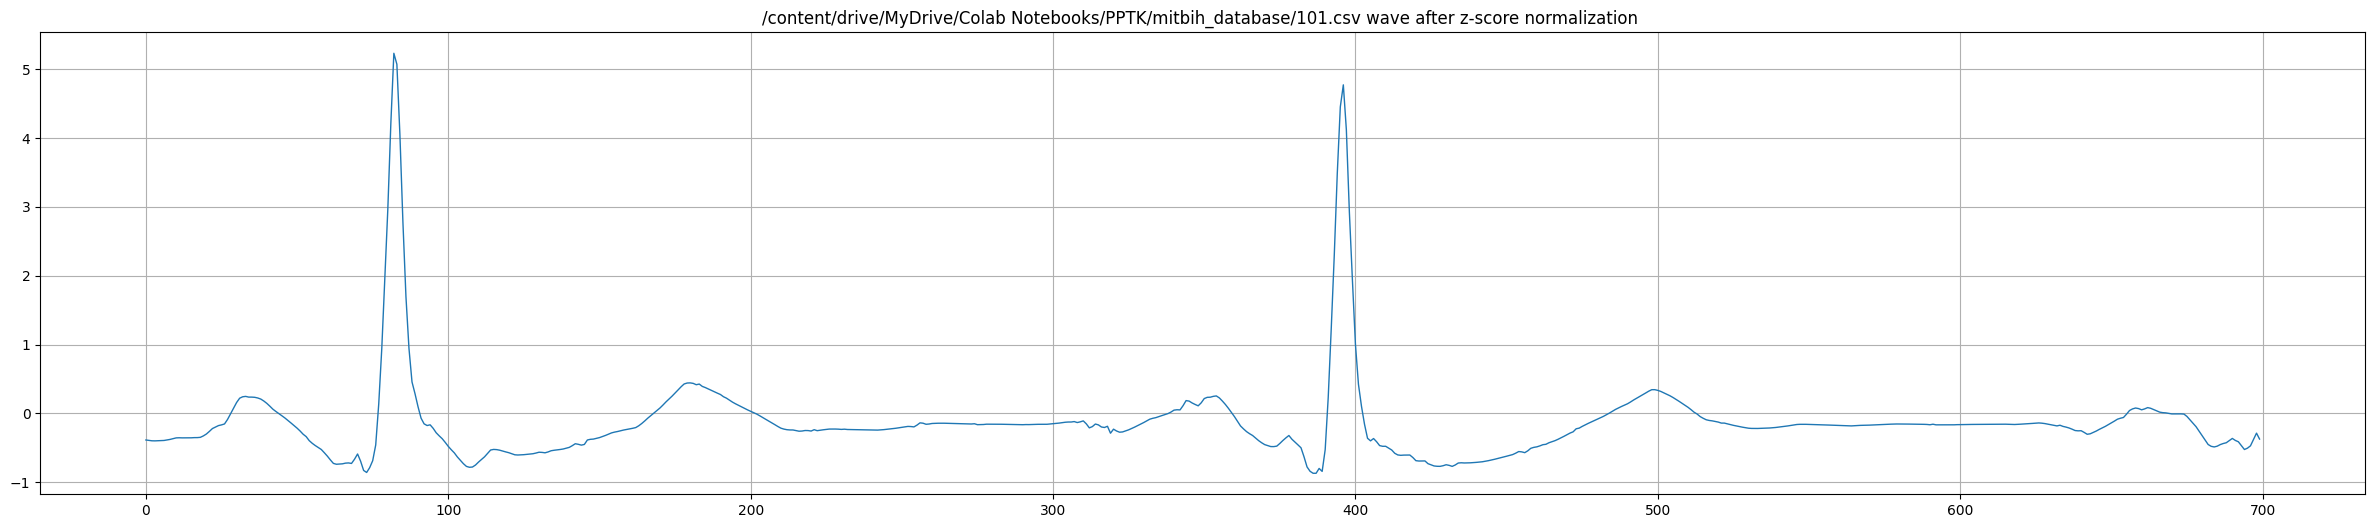

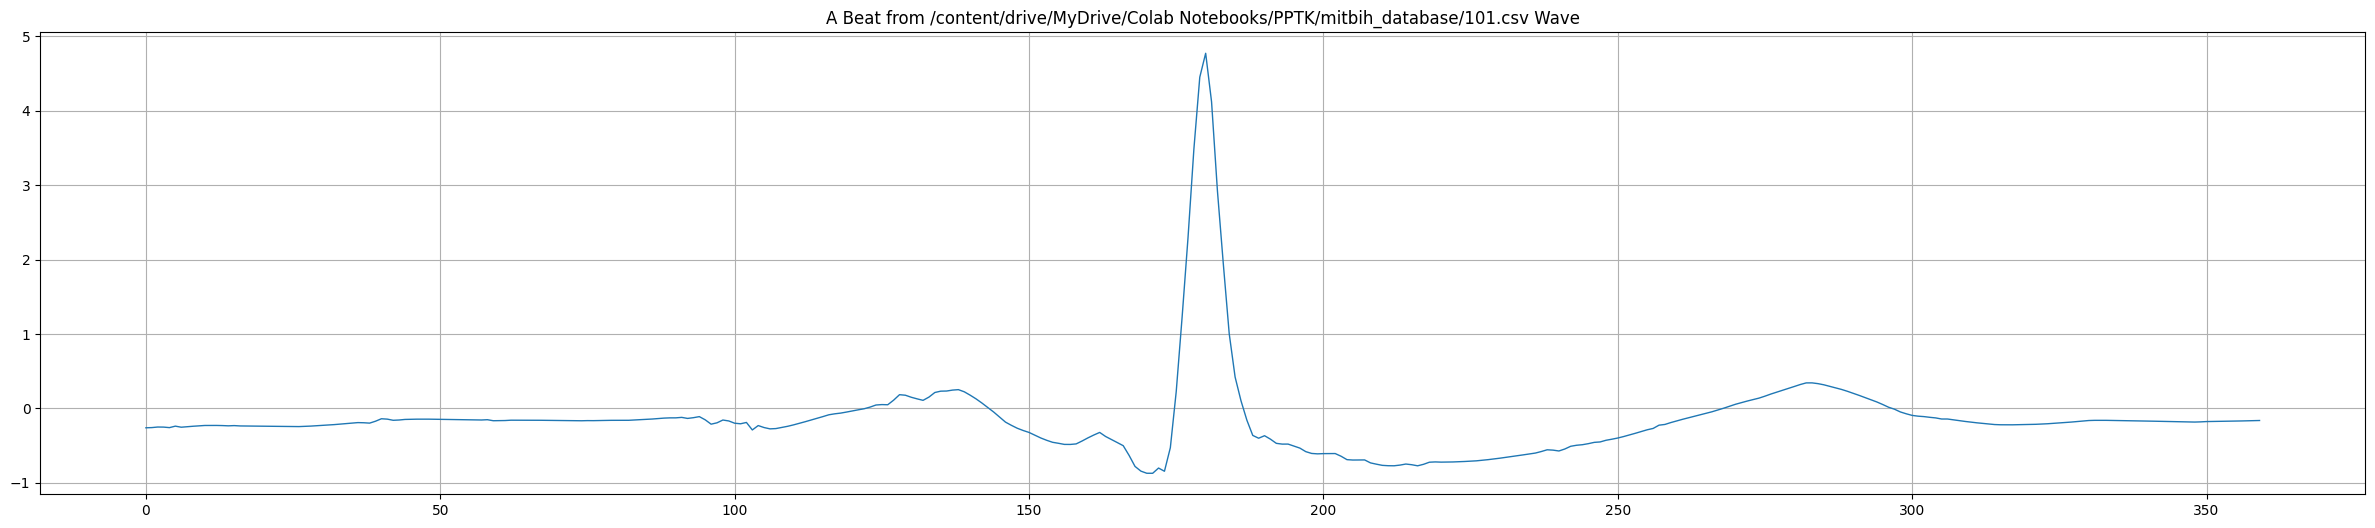

(100012, 360) (100012,)


In [9]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()

    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()

    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()

    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat
                    if r is 1 and not example_beat_printed:
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [10]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


# Classes Distribution

0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


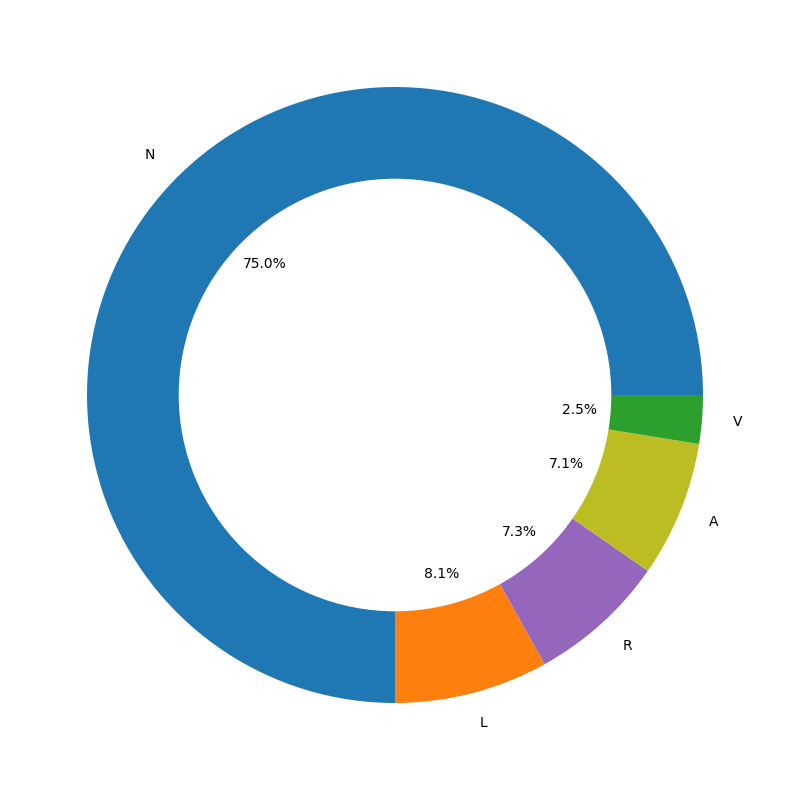

In [11]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Rebalancing Classes

In [12]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 360, dtype: int64


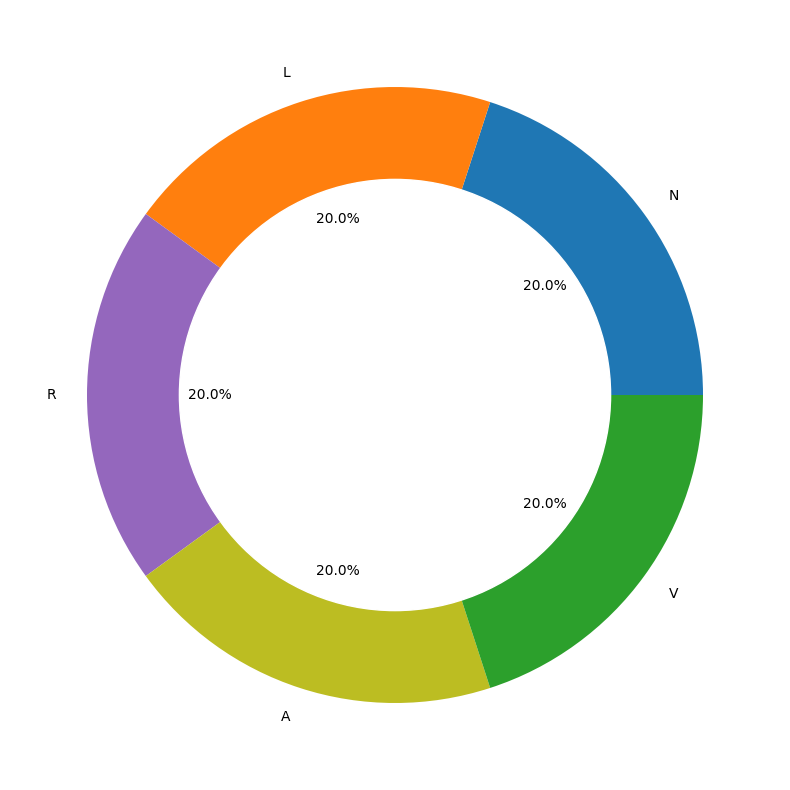

In [13]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Train-Test Split

In [14]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [15]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [16]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


In [17]:
# Define a function to extract wavelet features from ECG signals
def extract_wavelet_features(ecg_signal):
    numeric_signal = ecg_signal.astype(float)
    coeffs = pywt.wavedec(numeric_signal, 'rbio2.2', level=4)
    features = []
    for i, c in enumerate(coeffs):
        features.extend([np.mean(c), np.std(c), np.max(c), np.min(c)])
    return pd.Series(features)

# Apply wavelet feature extraction function to each ECG signal
data_train_wavelet = [extract_wavelet_features(row) for row in train_x.reshape(len(train_x), -1)]
data_test_wavelet = [extract_wavelet_features(row) for row in test_x.reshape(len(test_x), -1)]

# Convert the lists to DataFrames
data_train_wavelet = pd.DataFrame(data_train_wavelet)
data_test_wavelet = pd.DataFrame(data_test_wavelet)

# Concatenate wavelet features with original features
train_x_wavelet = pd.concat([pd.DataFrame(train_x.reshape(len(train_x), -1)), data_train_wavelet], axis=1)
test_x_wavelet = pd.concat([pd.DataFrame(test_x.reshape(len(test_x), -1)), data_test_wavelet], axis=1)

# Separate features and labels for the wavelet features
X_train_wavelet = train_x_wavelet.values.reshape(len(train_x_wavelet), train_x_wavelet.shape[1], 1)
X_test_wavelet = test_x_wavelet.values.reshape(len(test_x_wavelet), test_x_wavelet.shape[1], 1)


## Building the Model Architecture


In [21]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Flatten, Dropout, Softmax
from keras import regularizers

def ResidualBlock(model, inchannel, outchannel, stride=1):
    model.add(Conv1D(outchannel, kernel_size=3, strides=stride, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(outchannel, kernel_size=3, strides=1, padding='same', use_bias=False))
    model.add(BatchNormalization())

    if stride != 1 or inchannel != outchannel:
        model.add(Conv1D(outchannel, kernel_size=1, strides=stride, use_bias=False))
        model.add(BatchNormalization())

def ResNet18(input_shape=(380, 1), num_classes=5):
    model = Sequential()

    model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', use_bias=False, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    ResidualBlock(model, inchannel=64, outchannel=64, stride=1)
    ResidualBlock(model, inchannel=64, outchannel=128, stride=2)
    ResidualBlock(model, inchannel=128, outchannel=256, stride=2)
    ResidualBlock(model, inchannel=256, outchannel=512, stride=2)

    # Replace the AveragePooling1D layers with GlobalAveragePooling1D
    model.add(GlobalAveragePooling1D())

    model.add(Dense(35, kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
    model.add(Softmax())

    return model

# Create ResNet18 model
model2 = ResNet18(input_shape=(380, 1))
model2.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 380, 64)           192       
                                                                 
 batch_normalization_36 (Ba  (None, 380, 64)           256       
 tchNormalization)                                               
                                                                 
 activation_15 (Activation)  (None, 380, 64)           0         
                                                                 
 conv1d_25 (Conv1D)          (None, 380, 64)           12288     
                                                                 
 batch_normalization_37 (Ba  (None, 380, 64)           256       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 380, 64)          

## Compiling the model

In [22]:
model2.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

## Fitting the model

In [23]:
history2 = model2.fit(X_train_wavelet, train_y, batch_size=36, epochs=60, verbose=1, validation_data=(X_test_wavelet, test_y))

Epoch 1/60
556/556 [==============================] - 26s 23ms/step - loss: 0.4184 - accuracy: 0.8679 - val_loss: 0.3812 - val_accuracy: 0.8976
Epoch 2/60
556/556 [==============================] - 11s 20ms/step - loss: 0.2418 - accuracy: 0.9220 - val_loss: 0.3450 - val_accuracy: 0.8976
Epoch 3/60
556/556 [==============================] - 11s 21ms/step - loss: 0.1923 - accuracy: 0.9379 - val_loss: 0.4378 - val_accuracy: 0.8604
Epoch 4/60
556/556 [==============================] - 12s 21ms/step - loss: 0.1650 - accuracy: 0.9470 - val_loss: 0.3697 - val_accuracy: 0.8710
Epoch 5/60
556/556 [==============================] - 12s 21ms/step - loss: 0.1478 - accuracy: 0.9514 - val_loss: 0.3015 - val_accuracy: 0.8946
Epoch 6/60
556/556 [==============================] - 11s 20ms/step - loss: 0.1310 - accuracy: 0.9581 - val_loss: 0.3175 - val_accuracy: 0.8934
Epoch 7/60
556/556 [==============================] - 12s 21ms/step - loss: 0.1147 - accuracy: 0.9615 - val_loss: 0.3052 - val_accuracy:

**Plotting the loss convergence**

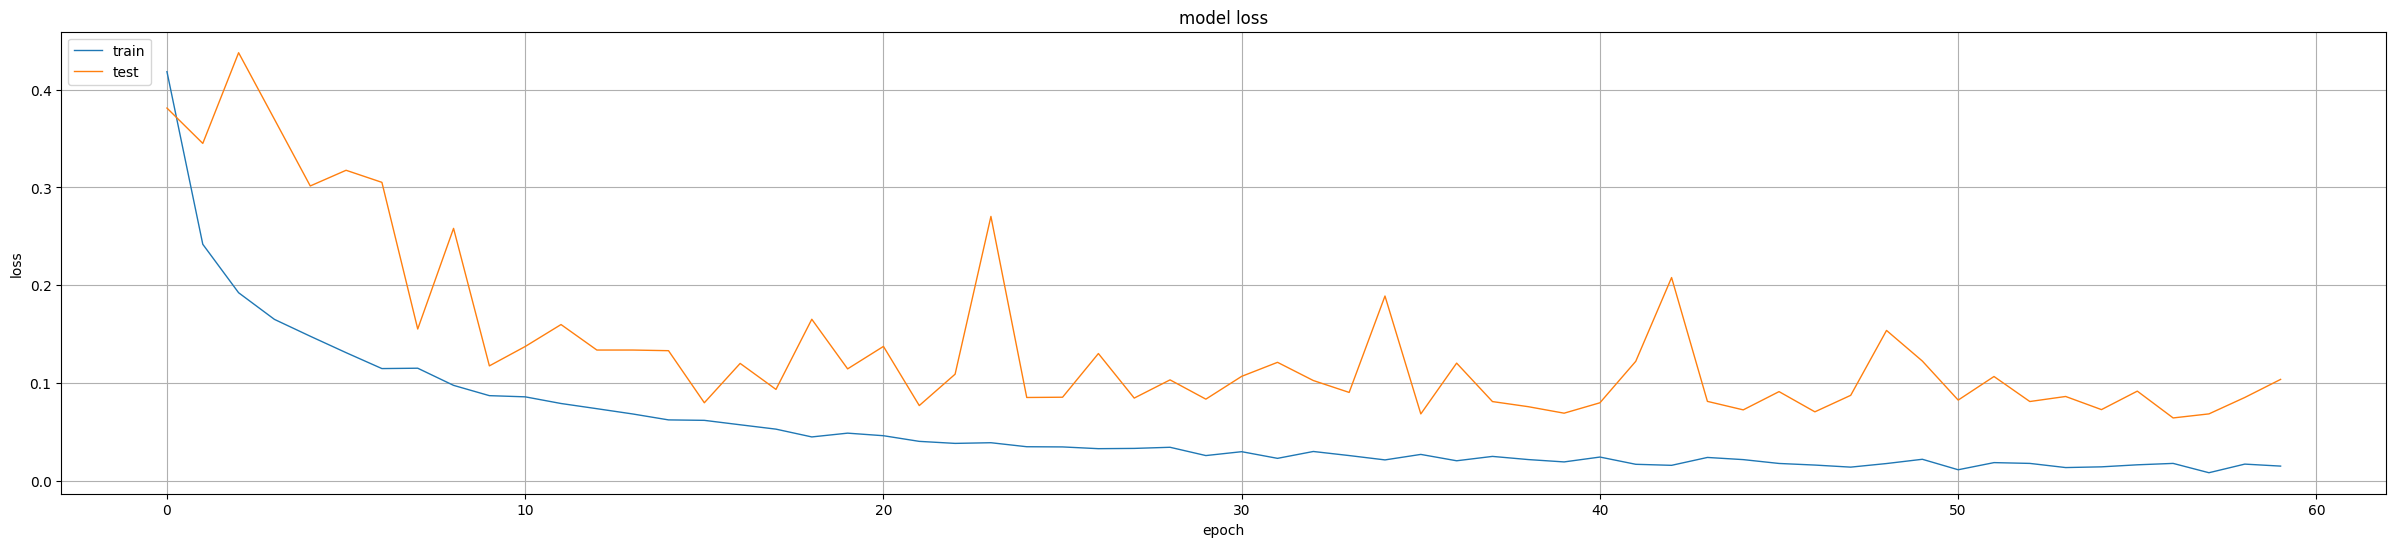

In [24]:
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Plotting accuracy**

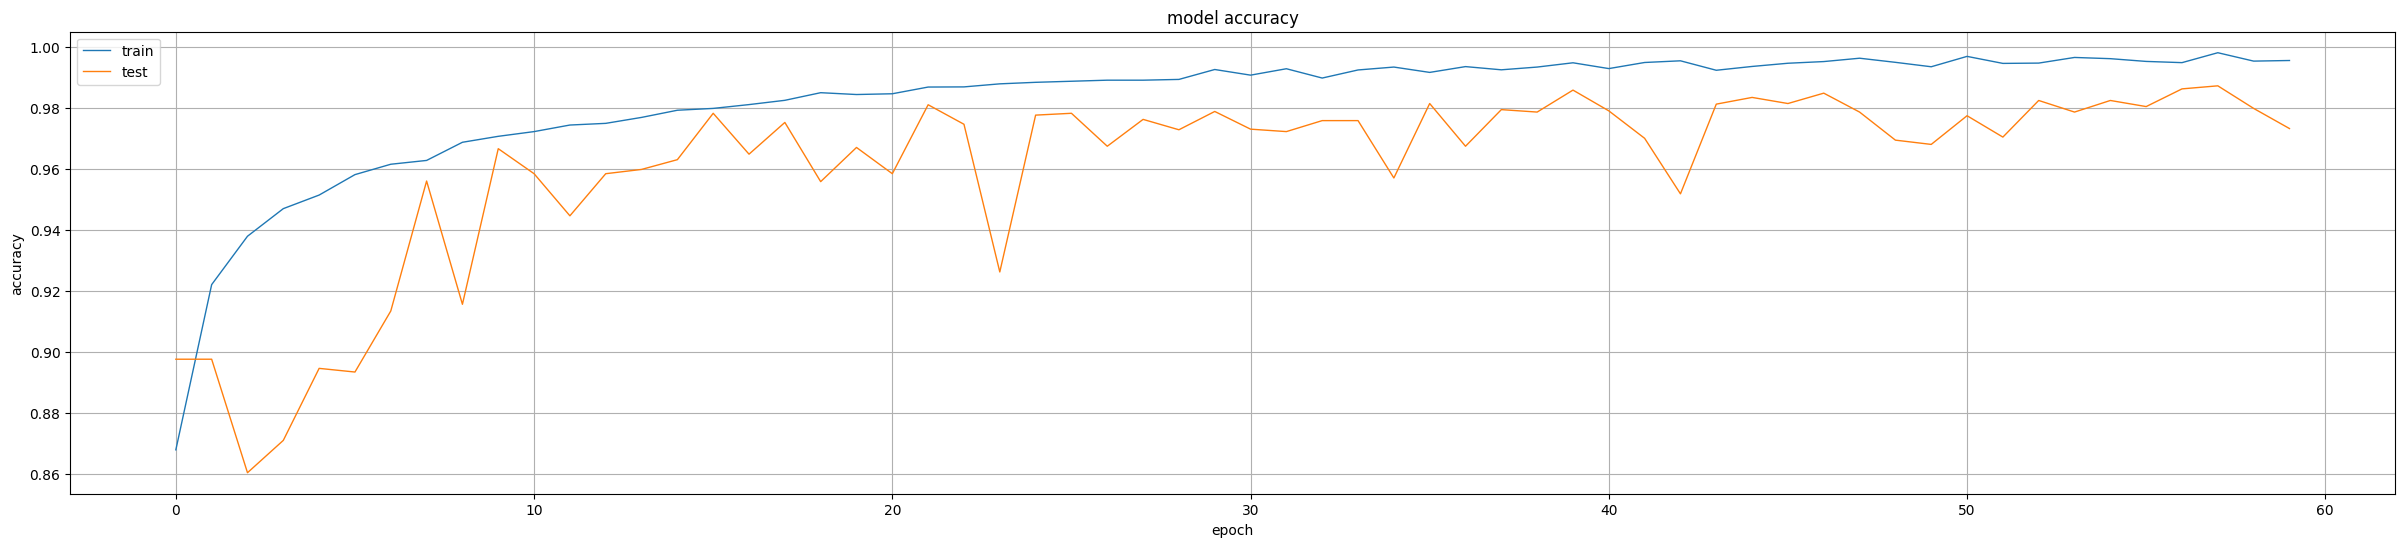

In [25]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Finding the loss and accuracy of the model

In [26]:
score = model2.evaluate(X_test_wavelet, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 1s 8ms/step - loss: 0.1036 - accuracy: 0.9732
Test Loss: 0.10359645634889603
Test accuracy: 0.9732000231742859


In [30]:
model2.save('/content/drive/MyDrive/Colab Notebooks/PPTK/ResNet18/Parameters/ResNet18-rbio2.2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
# Assuming you have predictions from your model
predictions = model2.predict(X_test_wavelet)

# Convert predictions to one-hot encoding
y_pred = np.argmax(predictions, axis=1)

# Convert true labels to one-hot encoding
y_true = np.argmax(test_y, axis=1)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# Calculate precision, recall, and F1 score
report = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report:")
print(report)

157/157 [==============================] - 3s 12ms/step
Confusion Matrix:
[[ 928   15   10   56    5]
 [   2 1010    0    0    1]
 [   3    2  946    5    0]
 [   9    4    4 1007    1]
 [   5   10    0    2  975]]
Classification Report:
              precision    recall  f1-score   support

           N       0.98      0.92      0.95      1014
           L       0.97      1.00      0.98      1013
           R       0.99      0.99      0.99       956
           A       0.94      0.98      0.96      1025
           V       0.99      0.98      0.99       992

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



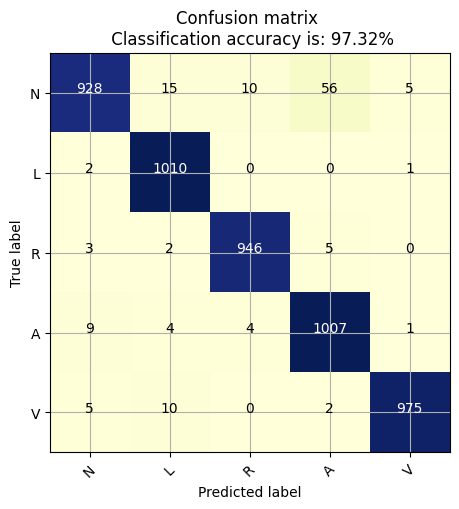

In [29]:
# Plot non-normalized confusion matrix
def plot_confusion_matrix(cm, classes,normalize=False,cmap="YlGnBu"):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    acc = "{:.2f}".format(np.trace(conf_mat)/np.sum(conf_mat)*100)
    plt.title('Confusion matrix \n Classification accuracy is: ' + str(acc)+'%')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(5, 5))
plot_confusion_matrix(conf_mat, classes=classes,normalize=False)
plt.show()